<a href="https://colab.research.google.com/github/Dacastror/Ataque_adversario_a_red_neuronal/blob/master/Ataques_Adversarios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import keras

import matplotlib.pyplot as plt
import numpy as np

from keras.applications.inception_v3 import InceptionV3, decode_predictions
from keras import backend as K
from keras.preprocessing import image

Using TensorFlow backend.


In [2]:
# modelo preentrenado de clasificacion de imagenes en 1000 clases diferentes
iv3 = InceptionV3()

96116736/96112376 [==============================] - 1s 0us/step


In [3]:
# obtener imagenes desde url
ruta_ima_input = "https://www.telesurtv.net/__export/1533261002478/sites/telesur/img/multimedia/2018/07/31/cerveza-dia-internacional-preparacion_mini.jpg_1810791533.jpg"
!wget "https://www.telesurtv.net/__export/1533261002478/sites/telesur/img/multimedia/2018/07/31/cerveza-dia-internacional-preparacion_mini.jpg_1810791533.jpg"

--2018-12-30 16:20:33--  https://www.telesurtv.net/__export/1533261002478/sites/telesur/img/multimedia/2018/07/31/cerveza-dia-internacional-preparacion_mini.jpg_1810791533.jpg
Resolving www.telesurtv.net (www.telesurtv.net)... 179.63.248.14, 190.185.106.220, 131.108.40.130
Connecting to www.telesurtv.net (www.telesurtv.net)|179.63.248.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20705 (20K) [image/jpeg]
Saving to: ‘cerveza-dia-internacional-preparacion_mini.jpg_1810791533.jpg’

cerveza-dia-interna 100%[===================>]  20.22K  --.-KB/s    in 0s      

2018-12-30 16:20:34 (262 MB/s) - ‘cerveza-dia-internacional-preparacion_mini.jpg_1810791533.jpg’ saved [20705/20705]



In [4]:
from pathlib import Path
p = Path(ruta_ima_input)
p.name

'cerveza-dia-internacional-preparacion_mini.jpg_1810791533.jpg'

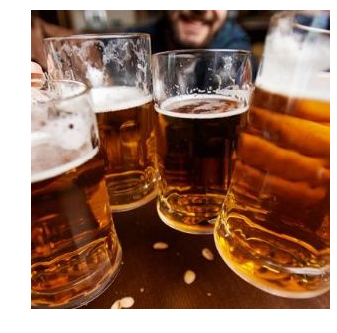

In [5]:
# cargar imagen y redimensionarla a 299 por 299
img = image.load_img(p.name, target_size=(299,299))
# obtener arreglo correspondiente a la imagen
x = image.img_to_array(img)
# mostrar imagen de entrada
plt.axis('off')
plt.imshow(img)

In [6]:
# cambio de rango de 0,255 a -1,1
x = ((x/255.0)-0.5)*2
# agregar una diminsion extra
x = x.reshape(1,x.shape[0],x.shape[1],x.shape[2])
# ejecutar modelo de clasificacion
y = iv3.predict(x)
# decodificar prediccion
decode_predictions(y)

40960/35363 [==================================] - 0s 1us/step


[[('n02823750', 'beer_glass', 0.9819864),
  ('n02815834', 'beaker', 0.00413355),
  ('n07930864', 'cup', 0.0013360056),
  ('n04560804', 'water_jug', 0.0012402328),
  ('n03950228', 'pitcher', 0.0009486994)]]

de acuerdo a lo anterior, el modelo de clasificación logró reconocer que se trataba de un vaso de cerveza con una probabilidad de 98.19864% de confianza ```('n02823750', 'beer_glass', 0.9819864)```

# Ataque adversario

In [7]:
# interceptar el nodo de entrada y el nodo de salida de la red
inp_layer = iv3.layers[0].input
out_layer = iv3.layers[-1].output

# numero correspondiente a la categoria "limon" en la base de datos ImageNet
target_class = 951
# seleccionar la categoria a maximizar
loss = out_layer[0, target_class]
# gradientes entre el input y la categoria de interes
grad = K.gradients(loss, inp_layer)[0]
# definir funcion de tipo keras (inputs, output deseado)
optimize_gradient = K.function([inp_layer, K.learning_phase()], [grad, loss])
adv = np.copy(x)

# perturbacion max permitida en los pixeles de la nueva imagen
pert = 1.01
min_pert = x - pert
max_pert = x + pert
# costo (error)
cost = 0.0
# se busca maximizar el error manteniendo perturbaciones pequenas en la imagen
while cost<0.95:
  # ejecutar la funcion definida arriba, que devuelve el grad y el coste
  # el K.learning_phase() igual a 0 significa modo testing
  gr, cost = optimize_gradient([adv,0])
  # sumar el valor del gradiente a la imagen
  adv += gr
  # limita la perturbacion max aplicada
  adv = np.clip(adv, min_pert, max_pert)
  # evitar la salida de rango de los pixeles
  adv = np.clip(adv, -1, 1)
  print("target cost: ",cost)

target cost:  9.22936e-05
target cost:  9.331861e-05
target cost:  9.436463e-05
target cost:  9.544347e-05
target cost:  9.654644e-05
target cost:  9.765649e-05
target cost:  9.878496e-05
target cost:  9.9950004e-05
target cost:  0.00010113845
target cost:  0.000102348014
target cost:  0.000103590064
target cost:  0.00010487642
target cost:  0.000106198146
target cost:  0.00010754525
target cost:  0.00010891589
target cost:  0.00011032536
target cost:  0.00011175947
target cost:  0.0001132156
target cost:  0.000114690556
target cost:  0.00011619648
target cost:  0.00011775624
target cost:  0.00011936571
target cost:  0.00012100741
target cost:  0.00012268024
target cost:  0.00012441157
target cost:  0.00012620137
target cost:  0.00012804965
target cost:  0.00012994006
target cost:  0.000131882
target cost:  0.00013389053
target cost:  0.000135958
target cost:  0.00013806373
target cost:  0.0001402092
target cost:  0.00014242307
target cost:  0.00014469252
target cost:  0.00014705295
ta

In [20]:
print(iv3.layers[0].input_shape)

(None, None, None, 3)


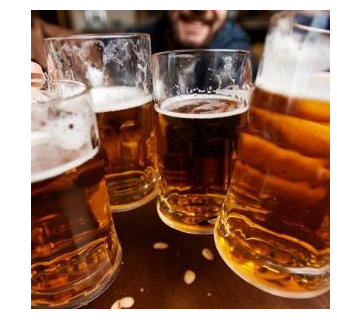

In [9]:
# cambiar rango de la imagen de -1,1 a 0,255
adv_hack2 = ((adv/2.0)+0.5)*255
# eliminar dimension extra y convertir a tipo uint8
adv_hack2 = adv_hack2[0].astype(np.uint8)
# mostrar imagen resultante
plt.axis('off')
plt.imshow(adv_hack2)
# guardar imagen resultante
name_out = 'cerveza_hack.png'
pred_img = image.array_to_img(adv_hack2)
pred_img.save(name_out)

## Probar resultado del ataque 

In [10]:
# cargar imagen hack
img_hack = image.load_img(name_out)
x_hack = image.img_to_array(img_hack)

# cambio de rango de 0,255 a -1,1
x_hack = ((x_hack/255.0)-0.5)*2
# agregar diminsion extra
x_hack = x_hack.reshape(1,x_hack.shape[0],x_hack.shape[1],x_hack.shape[2])
# ejecutar modelo de prediccion
y_hack = iv3.predict(x_hack)
# decodificar prediccion
decode_predictions(y_hack)

[[('n07749582', 'lemon', 0.99531233),
  ('n07747607', 'orange', 0.0017562284),
  ('n02823750', 'beer_glass', 0.0003040359),
  ('n03062245', 'cocktail_shaker', 0.00024610964),
  ('n07930864', 'cup', 0.00010561852)]]

De acuerdo al resultado anterior, la imagen generada por el ataque adversario logró engañar al modelo de clasificación que la clasifico como un limon con un porcentaje de confianza del 99.5407